# Gaussian Mixture Model

Key takeaways:
- the problem start with a univariate sample that should be a normal distribution but does not have a exact fit. There is suspicions of the sample being the product of subpopulations (ex.: weight of a person being a combination based on age, height and sex)
- there is not a 100% way to know which factor affected more the sample. For that, instead of attributing it like a binary, it is a probability.
- even with multinormal distribution, it is possible to determine which normal distribution have influenced more a specific subsample. But to do so, the parameters (mean and variance) is needed (it is the same with "I can't find work because I don't have experience, and I don't have experience because I can't find work".
- first we use a pre-determined parameters of pre-determined number of subdistributions, second the log of p.d.f. is calculated (or log-likelihood), third each sample is attributed to a subdistribution. This processs is called Expectation Maximization, and it is repeated until a specific condition in achieved (be a maximum number of iterations or a small enough change in log-likelihood)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from scipy.stats import shapiro 
import seaborn as sns

## Creating the dataset

Let's create a example dataset of age expectancy and other variables that is associated with it. For the sake of education, the basis assumption will be that age expectancy is a result of (1) exercise, (2) stress and (3) prevention by checkups.

First we will create the associated variables, and then use them to create the age expectancy sample.

In [4]:
df = pd.DataFrame(columns=['exercise', 'stress', 'prevention'])

### Exercise

Definition: average hours of moderate intensity activities done in a weekly basis.

In [5]:
mean = 5
std = 2

df['exercise'] = np.random.normal(mean, std, 100).round(2)

### Stress

Definition: made up index of stress levels.

In [6]:
mean = 7
std = 3

df['stress'] = np.random.normal(mean, std, 100).round(2)

### Prevention

Definition: number of months between visits to the doctor.

In [7]:
mean = 12
std = 3

df['prevention'] = np.random.normal(mean, std, 100).round(2)

In [8]:
df.sample(5)

,exercise,stress,prevention
25,2.44,9.20,8.22
12,6.47,9.29,16.10
11,4.85,4.20,8.13
44,3.18,9.41,12.05
24,5.93,9.61,11.29


### Age expectancy

It is to be expected that exercise and prevention have a positive effect in age expectancy, while stress have a negative effect. Supposed the formula to age expectancy is given by:




In [9]:
df['age'] = (df['exercise'] * 8 - df['stress'] * 3 + df['prevention'] * 3)

In [10]:
df.describe().round(2)

,exercise,stress,prevention,age
count,100.00,100.00,100.00,100.00
mean,5.13,7.31,11.93,54.85
std,1.94,3.04,3.08,19.47
min,0.28,0.76,4.22,16.31
25%,3.70,5.21,9.87,41.10
50%,4.95,7.26,12.09,52.02
75%,6.39,9.22,14.28,66.83
max,10.11,16.47,19.06,116.46


*obs: negative values does not make sense in real world, although it will be kept for educational purposes.*

Question: does `age` fit a normal distributions?

<AxesSubplot:xlabel='age', ylabel='Count'>

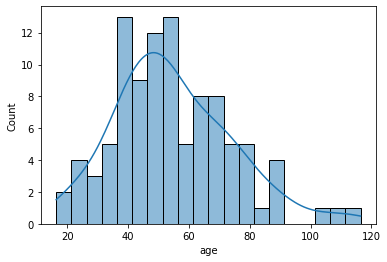

In [11]:
sns.histplot(df, x='age', bins=20, kde=True)

In [12]:
_, p = shapiro(df['age'])

if (p < 0.05):
    print('Yes, statistically speaking, it is normal distributed.')
else:
    print('No, statistically speaking, it is not normal distributed.')

Yes, statistically speaking, it is normal distributed.


From the result above, the result sample does not necessarily is normal distributed, even when created from other normal distribution subsamples.

## Reviewing required concepts 

Before proceding, this topic will cover required concepts used during the notebook.

<AxesSubplot:ylabel='Count'>

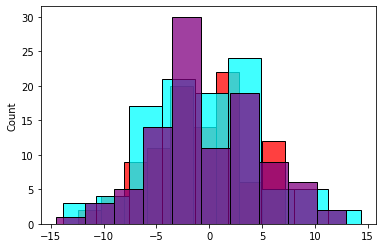

In [55]:
# Example data
a = np.random.normal(0, 5, 100).round(2)
b = np.random.normal(0, 5, 100).round(2)
c = np.random.normal(0, 5, 100).round(2)

sns.histplot(a, color='red')
sns.histplot(b, color='cyan') 
sns.histplot(c, color='purple') 

### Covariance matrix

In [56]:
# Set up the general case.
def variation(array_a, array_b):
    mean_a = array_a.mean()
    mean_b = array_b.mean()
    x = 1 / (len(array_a) - 1) * sum((array_a - mean_a) * (array_b - mean_b))
    print(x)

In [57]:
# Variance: how much a sample varies.
variation(a, a)

np.var(a, ddof=1)

19.712449656565653


19.712449656565656

In [58]:
# Covariance: how much two samples varies together.
variation(a, b)

np.cov(a, b)

-2.686434606060605


array([[19.71244966, -2.68643461],
       [-2.68643461, 29.47580819]])

In [59]:
# Covariance matrix: how much multiple samples varies together
abc = np.stack([a, b, c], axis=1)
np.cov(abc.T)

array([[19.71244966, -2.68643461, -0.27344127],
       [-2.68643461, 29.47580819,  0.04766637],
       [-0.27344127,  0.04766637, 26.26351243]])

### Multivariate gaussian

$f(x) = \frac{1}{\sqrt{(2 \pi)^k \det \Sigma}}
       \exp\left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right)$

In [165]:
# Example data
mean_array = np.array([a.mean(), b.mean()])
display(mean_array)

ab = np.stack([a, b], axis=1)
cov_matrix = np.cov(ab.T)
display(cov_matrix)

array([-0.9478, -0.4067])

array([[19.71244966, -2.68643461],
       [-2.68643461, 29.47580819]])

In [161]:
def gaussian_prob_density_function(array, mean, cov):
    size = len(array)
    escalar_part = 1/((2 * np.pi) ** size * np.linalg.det(cov)) ** (1/2)
    exp_part = np.exp(-1/2 * np.matmul(np.matmul((array - mean).reshape(1, size), np.linalg.inv(cov)), array - mean))
    pdf = escalar_part * exp_part

    return pdf[0]

gaussian_prob_density_function(array=ab[0], mean=mean_array, cov=cov_matrix)

0.0054051044978481845

In [166]:
# Check
mg = multivariate_normal(mean=mean_array, cov=cov_matrix)
mg.pdf(ab[0])

0.005405104497848185

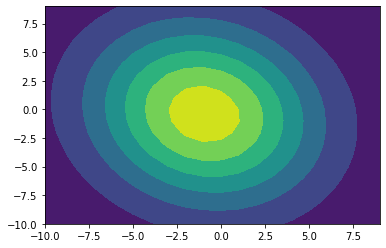

In [167]:
x, y = np.mgrid[-10:10:1, -10:10:1]
pos = np.dstack((x, y))
mn = multivariate_normal(mean=mean_array, cov=cov_matrix)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, mn.pdf(pos))

### Log Likelihood of a single Gaussian

Logarithm of the probability of a specific individual is part of a population.

In [14]:
mean = df['age'].mean()
std = df['age'].std()

df['age']

0      44.49
1      58.29
2      44.14
3      54.93
4      40.45
       ...  
95     23.81
96     65.14
97     40.26
98     51.55
99    116.46
Name: age, Length: 100, dtype: float64

In [ ]:
def log_likelihood():
    gaussian_prob_density_function

## Experimenting on 2D

### Normal distributed variables

### Non-normal distributed variables

### Highly correlated variables

### Non correlated variables